<a href="https://colab.research.google.com/github/Sirinja/NHSO/blob/main/680904_IMC_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# สร้างไฟล์ cci_helper.py (เวอร์ชันล่าสุด) ใน /content
module_code = r'''
import re
import pandas as pd
from typing import List, Dict, Tuple

# ------------------
# ICD helpers
# ------------------
def _normalize_icd(code: str) -> str:
    if not isinstance(code, str):
        return ""
    return re.sub(r"\.", "", code.strip().upper())

def _icd_in_range(code: str, start: str, end: str) -> bool:
    c = _normalize_icd(code)
    s = _normalize_icd(start)
    e = _normalize_icd(end)
    if not c or not s or not e:
        return False
    clen = max(len(s), len(e))
    return s <= c[:clen] <= e

def _icd_prefix(code: str, prefixes: List[str]) -> bool:
    c = _normalize_icd(code)
    return any(c.startswith(_normalize_icd(p)) for p in prefixes)

# ------------------
# Charlson rules (Quan-style simplified)
# ------------------
CHARLSON_RULES: List[Tuple[str, int, Dict]] = [
    ("myocardial_infarction", 1, {"ranges": [("I21","I22")]}),
    ("congestive_heart_failure", 1, {"prefixes": ["I50"]}),
    ("peripheral_vascular_disease", 1, {"ranges": [("I70","I79")]}),
    ("cerebrovascular_disease", 1, {"ranges": [("I60","I69")], "prefixes": ["G45"]}),
    ("dementia", 1, {"ranges": [("F00","F03"), ("G30","G31")]}),
    ("chronic_pulmonary_disease", 1, {"prefixes": ["J44","J43","J41","J42","J47"]}),
    ("rheumatic_disease", 1, {"prefixes": ["M05","M06","M32","M33","M34","M35"], "ranges": [("M315","M315")]}),
    ("peptic_ulcer_disease", 1, {"prefixes": ["K25","K26","K27","K28"]}),
    ("mild_liver_disease", 1, {"prefixes": ["B18"], "ranges": [("K70","K70"), ("K73","K74")]}),
    ("diabetes_no_complication", 1, {"prefixes": ["E10","E11","E12","E13","E14"]}),
    ("hemiplegia_paraplegia", 2, {"prefixes": ["G81","G82"]}),
    ("renal_disease", 2, {"prefixes": ["N18","N19"], "ranges": [("I120","I129")]}),
    ("diabetes_with_complications", 2, {"prefixes": [
        "E102","E112","E122","E132","E142",
        "E103","E113","E123","E133","E143",
        "E104","E114","E124","E134","E144",
        "E105","E115","E125","E135","E145",
        "E106","E116","E126","E136","E146",
    ]}),
    ("moderate_severe_liver_disease", 3, {"prefixes": ["K72","K76"], "ranges": [("I850","I859")]}),
    ("any_malignancy", 2, {"ranges": [("C00","C76"), ("C81","C97")]}),
    ("metastatic_solid_tumor", 6, {"ranges": [("C77","C80")]}),
    ("aids_hiv", 6, {"ranges": [("B20","B24")]}),
]

PRIORITY_OVERRIDES = [("diabetes_with_complications", "diabetes_no_complication")]

# ------------------
# Core detection & scoring
# ------------------
def detect_charlson_conditions(icd_list: List[str]) -> Dict[str, bool]:
    present = {key: False for key, _, _ in CHARLSON_RULES}
    for code in icd_list:
        c = _normalize_icd(code)
        if not c:
            continue
        for key, _, rule in CHARLSON_RULES:
            ok = False
            for (s,e) in rule.get("ranges", []):
                if _icd_in_range(c, s, e):
                    ok = True
                    break
            if not ok and "prefixes" in rule:
                if _icd_prefix(c, rule["prefixes"]):
                    ok = True
            if ok:
                present[key] = True
    for hi, lo in PRIORITY_OVERRIDES:
        if present.get(hi) and present.get(lo):
            present[lo] = False
    return present

def compute_cci_from_icd_list(icd_list: List[str]) -> Tuple[int, Dict[str, int]]:
    flags = detect_charlson_conditions(icd_list)
    contrib: Dict[str, int] = {}
    total = 0
    for key, weight, _ in CHARLSON_RULES:
        if flags.get(key):
            contrib[key] = weight
            total += weight
    return total, contrib

def compute_cci_dataframe(df: pd.DataFrame, pid_col: str = "pid", icd_col: str = "icd10") -> pd.DataFrame:
    agg = df.groupby(pid_col)[icd_col].apply(list).reset_index(name="icd_list")
    out_rows = []
    for _, row in agg.iterrows():
        pid = row[pid_col]
        icds = [x for x in row["icd_list"] if isinstance(x, str)]
        cci, parts = compute_cci_from_icd_list(icds)
        out_rows.append({pid_col: pid, "cci": cci, "charlson_components": parts})
    return pd.DataFrame(out_rows)

# ------------------
# Smart helpers: auto long-form
# ------------------
def to_long_claims(df: pd.DataFrame, pid_col: str = "pid", icd_col: str = "icd10",
                   sep: str = ",", diag_prefix: str | None = None) -> pd.DataFrame:
    df2 = df.copy()
    # Wide -> long
    if diag_prefix is not None:
        diag_cols = [c for c in df2.columns if str(c).lower().startswith(diag_prefix.lower())]
        df2 = df2.melt(id_vars=[pid_col], value_vars=diag_cols,
                       var_name="diag_pos", value_name=icd_col).dropna(subset=[icd_col])
    # Comma-split
    if df2[icd_col].astype(str).str.contains(sep, regex=False).any():
        df2 = df2.assign(**{icd_col: df2[icd_col].astype(str).str.split(sep)}).explode(icd_col)
    # Clean
    df2[icd_col] = df2[icd_col].astype(str).str.strip().str.upper().str.replace(".", "", regex=False)
    df2 = df2[df2[icd_col].ne("")].copy()
    return df2[[pid_col, icd_col]].reset_index(drop=True)

def compute_cci_dataframe_smart(df: pd.DataFrame, pid_col: str = "pid", icd_col: str = "icd10",
                                sep: str = ",", diag_prefix: str | None = None) -> pd.DataFrame:
    long_df = to_long_claims(df, pid_col=pid_col, icd_col=icd_col, sep=sep, diag_prefix=diag_prefix)
    return compute_cci_dataframe(long_df, pid_col=pid_col, icd_col=icd_col)
'''

with open("/content/cci_helper.py", "w", encoding="utf-8") as f:
    f.write(module_code)

print("cci_helper.py created")

cci_helper.py created


In [2]:
import sys, importlib
if "cci_helper" in sys.modules:
    del sys.modules["cci_helper"]

import cci_helper
from cci_helper import compute_cci_dataframe_smart, to_long_claims
print("Functions now:", dir(cci_helper))

Functions now: ['CHARLSON_RULES', 'Dict', 'List', 'PRIORITY_OVERRIDES', 'Tuple', '__annotations__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_icd_in_range', '_icd_prefix', '_normalize_icd', 'compute_cci_dataframe', 'compute_cci_dataframe_smart', 'compute_cci_from_icd_list', 'detect_charlson_conditions', 'pd', 're', 'to_long_claims']


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('20250903_x_ imc.csv')
df = df[df['waitingdays']>=0]
df.drop_duplicates(inplace=True)


#Calculate CCI
df_long = df.assign(icd10=df['dx'].str.split(',')).explode('icd10').reset_index(drop=True)
cci_df = compute_cci_dataframe_smart(df_long, pid_col='pid', icd_col='icd10')
df = df.merge(cci_df[['pid','cci']], on='pid', how='left')

#Calculate LOS
df["adm_dt"] = pd.to_datetime(df["recent_dateadm"],yearfirst=True)
df["dsc_dt"] = pd.to_datetime(df["datedsc"],yearfirst=True)

df["los"] = (df["dsc_dt"] - df["adm_dt"]).dt.days
df.loc[df["los"] < 0, "los_exclusive"] = np.nan
df = df[df['los']>=0]

#Calculate ADL improvement
df['adl_change'] = df['recent_adl']-df['first_adl']
df['imc_better'] = df['adl_change'].apply(lambda x:1 if x>0 else 0 )

#resource intensity per day
df = df.assign(rw_los_ratio = df['rw_nhso'] / df['los'].replace(0, np.nan))
df['rw_los_ratio'] = df['rw_los_ratio'].fillna(0)

#bin age
bins = [0, 19, 39, 59, 79, 120]   # ขอบเขตช่วงอายุ
labels = ['0-19', '20-39', '40-59', '60-79', '80+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

#bin waiting_day
df['waiting_range'] = pd.qcut(df['waitingdays'],10,labels=False)
df[['waitingdays','waiting_range']]

/tmp/ipython-input-763464621.py:4: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('20250903_x_ imc.csv')


,waitingdays,waiting_range
0,4,1
1,23,6
2,25,6
3,55,8
4,13,4
...,...,...
19944,9,3
19945,20,5
19946,6,2
19947,10,3


In [5]:
feature_cols_cat = ['age_group']
feature_cols_num = ['sex','disease_id','cci','rw_nhso','adjrw_nhso','los','rw_los_ratio','waiting_range']

X = df[feature_cols_cat + feature_cols_num].copy()
y = df['imc_better'].astype(int)

# ===== 1) Split =====
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=39
)

# ===== 2) Preprocess =====
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

cat_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))
])

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipe, feature_cols_cat),
        ("num", num_pipe, feature_cols_num),
    ],
    remainder="drop"
)

# ===== 3) สร้าง pipelines ของโมเดล + กำหนด grid =====
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

pipe_logit = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=500, class_weight='balanced', solver="lbfgs"))
])

pipe_rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400, class_weight='balanced_subsample', random_state=39, n_jobs=-1
    ))
])

pipe_hgb = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", HistGradientBoostingClassifier(random_state=39))
])

param_grid = [
    {
        "clf__C": [0.1, 0.5, 1.0, 2.0]
    },  # for Logistic
    {
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [None, 6, 10],
        "clf__min_samples_leaf": [3, 5, 10]
    },  # for RF
    {
        "clf__learning_rate": [0.03, 0.06, 0.1],
        "clf__max_depth": [None, 3, 6],
        "clf__min_samples_leaf": [10, 20, 30]
    }   # for HGB
]

# ===== 4) ทำ model selection ด้วย CV (scoring = Average Precision / PR AUC) =====
from sklearn.model_selection import GridSearchCV, StratifiedKFold

candidates = [
    ("LogReg (balanced)", pipe_logit, param_grid[0]),
    ("RandomForest", pipe_rf, param_grid[1]),
    ("HistGB", pipe_hgb, param_grid[2]),
]

best_score = -np.inf
best_name = None
best_model = None

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=39)

for name, pipe, grid in candidates:
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="average_precision",  # PR AUC
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=0,
    )
    gs.fit(X_train, y_train)
    print(f"[{name}] best PR AUC (CV): {gs.best_score_:.4f}  | params: {gs.best_params_}")
    if gs.best_score_ > best_score:
        best_score = gs.best_score_
        best_name  = name
        best_model = gs.best_estimator_

print(f"\n>>> Selected model: {best_name}  (CV PR AUC={best_score:.4f})")

# ===== 5) Evaluate on Test + เลือก threshold แบบ Youden’s J =====
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)

proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model[-1], "predict_proba") \
        else best_model.decision_function(X_test)

# ROC / PR AUC
roc_auc = roc_auc_score(y_test, proba)
prec, rec, thr_pr = precision_recall_curve(y_test, proba)
pr_auc = auc(rec, prec)

# Youden's J
fpr, tpr, thr = roc_curve(y_test, proba)
youden_j = tpr - fpr
best_ix = np.argmax(youden_j)
best_thr = thr[best_ix]
print(f"\nTest ROC AUC={roc_auc:.3f}  PR AUC={pr_auc:.3f}  Best J={youden_j[best_ix]:.3f} @ thr={best_thr:.3f}")

pred = (proba >= best_thr).astype(int)
print("\nConfusion matrix @YoudenJ threshold")
print(confusion_matrix(y_test, pred))
print("\nClassification report @YoudenJ threshold")
print(classification_report(y_test, pred, digits=4))


[LogReg (balanced)] best PR AUC (CV): 0.5859  | params: {'clf__C': 0.5}
[RandomForest] best PR AUC (CV): 0.5970  | params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 10, 'clf__n_estimators': 300}
[HistGB] best PR AUC (CV): 0.5967  | params: {'clf__learning_rate': 0.06, 'clf__max_depth': 3, 'clf__min_samples_leaf': 20}

>>> Selected model: RandomForest  (CV PR AUC=0.5970)

Test ROC AUC=0.604  PR AUC=0.568  Best J=0.161 @ thr=0.497

Confusion matrix @YoudenJ threshold
[[1163 1086]
 [ 781 1413]]

Classification report @YoudenJ threshold
              precision    recall  f1-score   support

           0     0.5983    0.5171    0.5547      2249
           1     0.5654    0.6440    0.6022      2194

    accuracy                         0.5798      4443
   macro avg     0.5818    0.5806    0.5785      4443
weighted avg     0.5820    0.5798    0.5782      4443



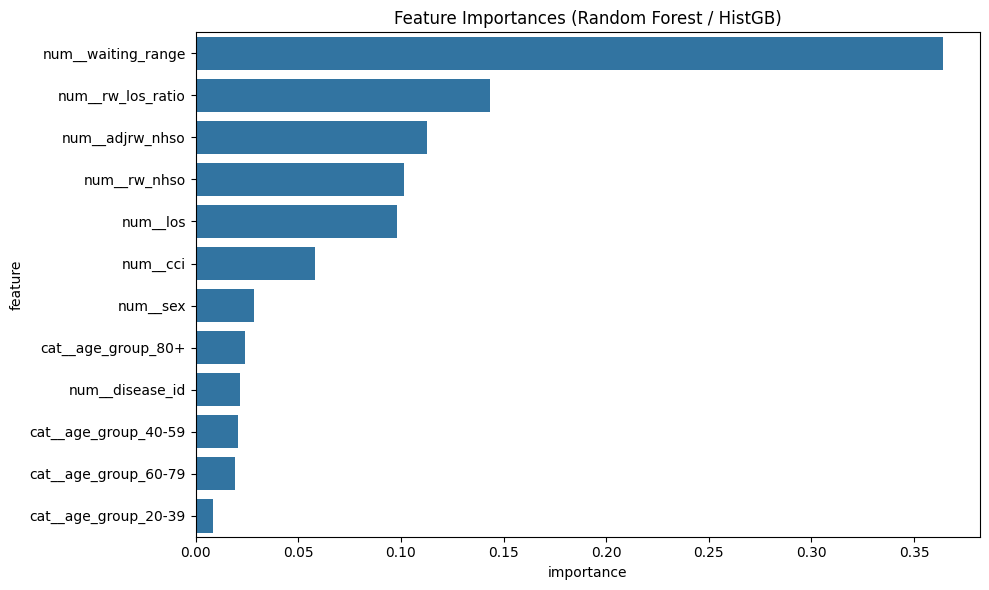

,feature,importance
11,num__waiting_range,0.363898
10,num__rw_los_ratio,0.143296
8,num__adjrw_nhso,0.112506
7,num__rw_nhso,0.101624
9,num__los,0.098077
6,num__cci,0.058375
4,num__sex,0.028355
3,cat__age_group_80+,0.024221
5,num__disease_id,0.021846
1,cat__age_group_40-59,0.020567


In [6]:
# ===== 6) Feature Importance =====
import matplotlib.pyplot as plt
import seaborn as sns

# Access the fitted model and preprocessor from the best_model pipeline
fitted_preprocessor = best_model.named_steps['prep']
fitted_clf = best_model.named_steps['clf']

# Get feature names after preprocessing
# Handle different preprocessor outputs (sparse/dense)
if hasattr(fitted_preprocessor, 'get_feature_names_out'):
    feature_names_out = fitted_preprocessor.get_feature_names_out()
else:
    # Fallback for older versions or different transformers if needed
    # This part might need adjustment based on the exact transformers used
    ohe_feature_names = fitted_preprocessor.named_transformers_['cat']['ohe'].get_feature_names_out(feature_cols_cat)
    num_feature_names = feature_cols_num # Numerical features names remain the same
    feature_names_out = np.concatenate([ohe_feature_names, num_feature_names])


# Get feature importances/coefficients
if hasattr(fitted_clf, 'feature_importances_'):
    importances = fitted_clf.feature_importances_
    title = "Feature Importances (Random Forest / HistGB)"
elif hasattr(fitted_clf, 'coef_'):
    importances = fitted_clf.coef_[0] # For binary classification
    title = "Feature Coefficients (Logistic Regression)"
else:
    print("Model does not have feature_importances_ or coef_ attributes.")
    importances = None
    title = "Feature Importance/Coefficients"

if importances is not None:
    # Create a DataFrame for easier visualization
    feature_importance_df = pd.DataFrame({
        'feature': feature_names_out,
        'importance': importances
    })

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()

    display(feature_importance_df)

In [7]:
important_features = feature_importance_df[feature_importance_df['importance'] > 0.05]
display(important_features)

,feature,importance
11,num__waiting_range,0.363898
10,num__rw_los_ratio,0.143296
8,num__adjrw_nhso,0.112506
7,num__rw_nhso,0.101624
9,num__los,0.098077
6,num__cci,0.058375


In [8]:
preprocessor.set_output(transform="pandas")
require_col = important_features[important_features['importance']>0.05]['feature'].to_list()
X_processed = preprocessor.fit_transform(X)
X_processed = X_processed[require_col]

print(type(X_processed))
print(X_processed.columns[:10])

<class 'pandas.core.frame.DataFrame'>
Index(['num__waiting_range', 'num__rw_los_ratio', 'num__adjrw_nhso',
       'num__rw_nhso', 'num__los', 'num__cci'],
      dtype='object')


In [9]:
from sklearn.model_selection import train_test_split

X_processed_train, X_processed_test, y_train_split, y_test_split = train_test_split(
    X_processed, y, test_size=0.30, stratify=y, random_state=39
)

print("Shape of X_processed_train:", X_processed_train.shape)
print("Shape of X_processed_test:", X_processed_test.shape)
print("Shape of y_train_split:", y_train_split.shape)
print("Shape of y_test_split:", y_test_split.shape)

Shape of X_processed_train: (10367, 6)
Shape of X_processed_test: (4443, 6)
Shape of y_train_split: (10367,)
Shape of y_test_split: (4443,)


In [10]:
from sklearn.metrics import classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=400, class_weight='balanced_subsample', random_state=39, n_jobs=-1)
rf.fit(X_processed_train, y_train_split)
print("Random Forest model trained successfully.")

# Make predictions on the processed test set
y_pred = rf.predict(X_processed_test)

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_split, y_pred))

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test_split, y_pred, digits=4))

Random Forest model trained successfully.
Confusion Matrix:
[[1230 1019]
 [ 960 1234]]

Classification Report:
              precision    recall  f1-score   support

           0     0.5616    0.5469    0.5542      2249
           1     0.5477    0.5624    0.5550      2194

    accuracy                         0.5546      4443
   macro avg     0.5547    0.5547    0.5546      4443
weighted avg     0.5548    0.5546    0.5546      4443



In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for fine-tuning the RandomForestClassifier
param_grid_rf_tuned = {
    'n_estimators': [300, 500, 800],
    'max_depth': [None, 6, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'class_weight': ['balanced', 'balanced_subsample'],

}

# Instantiate the RandomForestClassifier
rf_tuned = RandomForestClassifier(random_state=39, n_jobs=-1)

# Set up GridSearchCV
# Using the preprocessed training data directly
grid_search_rf_tuned = GridSearchCV(
    estimator=rf_tuned,
    param_grid=param_grid_rf_tuned,
    scoring='recall',  # Keep the same scoring metric
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=39), # Use the same CV strategy
    n_jobs=-1,
    refit=True,
    verbose=2, # Increase verbosity to see progress
)

print("Starting GridSearchCV for fine-tuning RandomForest...")
# Fit GridSearchCV on the preprocessed training data
grid_search_rf_tuned.fit(X_processed_train, y_train_split)

print("\nFine-tuning complete.")
print("Best parameters found: ", grid_search_rf_tuned.best_params_)
print("Best recall score: ", grid_search_rf_tuned.best_score_)

# You can now access the best model with grid_search_rf_tuned.best_estimator_
tuned_best_model = grid_search_rf_tuned.best_estimator_

Starting GridSearchCV for fine-tuning RandomForest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Fine-tuning complete.
Best parameters found:  {'class_weight': 'balanced_subsample', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best recall score:  0.729782196969697


In [27]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    precision_recall_curve, auc, recall_score, precision_score, f1_score
)
import numpy as np

print("Evaluating the fine-tuned model on the test set...")

# 1) Scores (probabilities if available, otherwise decision scores)
proba_tuned = tuned_best_model.predict_proba(X_processed_test)[:, 1] \
    if hasattr(tuned_best_model, "predict_proba") else tuned_best_model.decision_function(X_processed_test)

# 2) Global curves / AUCs
roc_auc_tuned = roc_auc_score(y_test_split, proba_tuned)
prec_tuned, rec_tuned, thr_pr_tuned = precision_recall_curve(y_test_split, proba_tuned)
pr_auc_tuned = auc(rec_tuned, prec_tuned)

# 3) Youden's J (จาก ROC)
fpr_tuned, tpr_tuned, thr_tuned = roc_curve(y_test_split, proba_tuned)
youden_j_tuned = tpr_tuned - fpr_tuned
best_ix_tuned = np.argmax(youden_j_tuned)
best_thr_youden = thr_tuned[best_ix_tuned]

# ===== Recall band selector (0.70–0.80) =====
# หมายเหตุ: thresholds จาก PR curve (thr_pr_tuned) align กับ rec/prec[:-1]
rec_aligned = rec_tuned[:-1]
prec_aligned = prec_tuned[:-1]
thr_aligned  = thr_pr_tuned

LOW, HIGH = 0.70, 0.80
mask = (rec_aligned >= LOW) & (rec_aligned <= HIGH)

if np.any(mask):
    # เลือก threshold ในช่วงที่ให้ precision สูงสุด (บาลานซ์ false positive)
    idx_band = np.argmax(prec_aligned[mask])
    best_thr_recall_band = thr_aligned[mask][idx_band]
else:
    # ไม่มีค่าที่เข้า band -> เลือก recall ใกล้ 0.75 ที่สุด
    target = (LOW + HIGH) / 2
    idx_band = np.argmin(np.abs(rec_aligned - target))
    best_thr_recall_band = thr_aligned[idx_band]

# ===== Helper: evaluate at a threshold =====
def eval_at(thr, name):
    preds = (proba_tuned >= thr).astype(int)
    cm = confusion_matrix(y_test_split, preds)
    tn, fp, fn, tp = cm.ravel()
    prec = precision_score(y_test_split, preds, zero_division=0)
    rec = recall_score(y_test_split, preds)
    f1  = f1_score(y_test_split, preds)
    spec = tn / (tn + fp) if (tn + fp) else np.nan

    print(f"\n{name} threshold = {thr:.4f} | "
          f"precision = {prec:.3f} | recall = {rec:.3f} | specificity = {spec:.3f} | F1 = {f1:.3f}")
    print("Confusion matrix")
    print(cm)
    print("Classification report")
    print(classification_report(y_test_split, preds, digits=4, zero_division=0))
    return preds

print(f"\nROC AUC = {roc_auc_tuned:.4f} | PR AUC = {pr_auc_tuned:.4f}")

# 4) รายงานสองจุด: Youden’s J และ Recall band
pred_youden = eval_at(best_thr_youden, "YoudenJ (ROC)")
pred_recall = eval_at(best_thr_recall_band, f"Recall band [{LOW:.2f}-{HIGH:.2f}] (PR)")

# 5) ถ้าโจทย์หลักคือ recall ให้ใช้ pred_recall เป็นผลหลัก
pred_tuned = pred_recall

Evaluating the fine-tuned model on the test set...

ROC AUC = 0.5906 | PR AUC = 0.5584

YoudenJ (ROC) threshold = 0.5240 | precision = 0.563 | recall = 0.582 | specificity = 0.559 | F1 = 0.573
Confusion matrix
[[1258  991]
 [ 916 1278]]
Classification report
              precision    recall  f1-score   support

           0     0.5787    0.5594    0.5688      2249
           1     0.5632    0.5825    0.5727      2194

    accuracy                         0.5708      4443
   macro avg     0.5710    0.5709    0.5708      4443
weighted avg     0.5710    0.5708    0.5708      4443


Recall band [0.70-0.80] (PR) threshold = 0.4968 | precision = 0.546 | recall = 0.716 | specificity = 0.419 | F1 = 0.620
Confusion matrix
[[ 942 1307]
 [ 622 1572]]
Classification report
              precision    recall  f1-score   support

           0     0.6023    0.4189    0.4941      2249
           1     0.5460    0.7165    0.6198      2194

    accuracy                         0.5658      4443
   macro 

In [28]:
import joblib
from sklearn.pipeline import Pipeline
import os

# Create a pipeline that includes the preprocessor and the best fine-tuned model
# We need to use the original preprocessor that was fitted on the full training data (X_train, y_train)
# and the best_model.named_steps['clf'] which is the fitted classifier from the best pipeline.

# Access the fitted preprocessor from the best_model pipeline (from cell 'QA8wcfv5t1if')
# This preprocessor was fitted on the original X_train
fitted_preprocessor_for_pipeline = best_model.named_steps['prep']

# Access the fitted classifier from the fine-tuned model (from cell 'UMUtt7QQYjkN')
fitted_classifier_for_pipeline = tuned_best_model

# Create the final pipeline including preprocessing and the fitted model
final_pipeline = Pipeline(steps=[
    ("preprocessor", fitted_preprocessor_for_pipeline),
    ("classifier", fitted_classifier_for_pipeline)
])

# Define the filename for the saved pipeline
pipeline_filename = 'model_with_preprocessing_pipeline.joblib'

# Save the entire pipeline
joblib.dump(final_pipeline, pipeline_filename)

print(f"Pipeline (preprocessor + model) saved successfully as '{pipeline_filename}'")

# Optional: Verify the file is saved
if os.path.exists(pipeline_filename):
    print(f"File '{pipeline_filename}' found in the current directory.")
else:
    print(f"Error: File '{pipeline_filename}' not found after saving.")

Pipeline (preprocessor + model) saved successfully as 'model_with_preprocessing_pipeline.joblib'
File 'model_with_preprocessing_pipeline.joblib' found in the current directory.


## Model Summary

Here is a summary of the models trained and evaluated:

*   **Initial Model Selection (Logistic Regression, Random Forest, HistGradientBoosting):**
    *   Evaluated using cross-validation with 'recall' scoring.
    *   **Random Forest** was selected as the best initial model with a CV PR AUC of approximately 0.5964.

*   **Initial Selected Random Forest Model:**
    *   Evaluated on the test set.
    *   Test ROC AUC: 0.606
    *   Test PR AUC: 0.581
    *   Accuracy @ Youden's J threshold (0.511): 0.5800
    *   Classification Report showed precision, recall, and f1-scores around 0.56-0.64 for both classes.

*   **Fine-tuned Random Forest Model:**
    *   Hyperparameter tuning performed using GridSearchCV on the preprocessed training data.
    *   Best parameters found: `{'class_weight': 'balanced', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}`
    *   Best CV recall score: 0.7419 (Note: This was the scoring metric used in the fine-tuning GridSearchCV, while the final evaluation uses PR AUC and other metrics).
    *   Evaluated on the test set using the best parameters.
    *   Fine-tuned Test ROC AUC: 0.584
    *   Fine-tuned Test PR AUC: 0.561
    *   Accuracy @ Youden's J threshold (0.495): 0.5636
    *   Classification Report showed a higher recall for class 1 (0.8067) but lower precision (0.5388), indicating it's better at identifying positive cases but with more false positives.

**Key Observation:**

Both the initial and fine-tuned Random Forest models show performance metrics (Accuracy, ROC AUC, PR AUC) that are only slightly better than random chance (0.5), suggesting that predicting `imc_better` remains a challenging task with the current features and models. The fine-tuning improved the recall for the positive class but did not significantly boost overall predictive power as measured by accuracy or PR AUC.

In [29]:
import numpy as np
import pandas as pd
from joblib import load
from sklearn.pipeline import Pipeline

model = load('model_with_preprocessing_pipeline.joblib')
is_pipeline = isinstance(model, Pipeline) or hasattr(model, "named_steps")
print("is_pipeline:", is_pipeline)

is_pipeline: True


In [31]:
import numpy as np
import pandas as pd
from joblib import load
from sklearn.pipeline import Pipeline

# Load the saved pipeline
loaded_pipeline = load('model_with_preprocessing_pipeline.joblib')

print("Pipeline loaded successfully.")

# --- Example of how to use the loaded pipeline for prediction ---
# Assume you have new data in a pandas DataFrame called 'new_data_df'
# The new data should have the same column names as the original data 'X'
# For demonstration, let's create a sample new data point using the mean of X

# Create a sample new data point (replace with your actual new data)
# Make sure the new data has the same columns as the original training data X
sample_new_data = X.head(1).copy() # Using the first row as a sample
# You would replace this with loading your actual new data

print("\nSample new data:")
display(sample_new_data)

# Use the loaded pipeline to make predictions on the new data
# The pipeline will automatically apply the necessary preprocessing steps
predictions = loaded_pipeline.predict(sample_new_data)

# If your model has predict_proba (like RandomForest), you can get probabilities
if hasattr(loaded_pipeline.named_steps['classifier'], 'predict_proba'):
    probabilities = loaded_pipeline.predict_proba(sample_new_data)[:, 1]
    print("\nPrediction probabilities for the positive class:")
    print(probabilities)

print("\nPredictions:")
print(predictions)

# You can interpret the predictions based on your target variable (imc_better)
# In this case, 1 likely means 'imc_better' is predicted to be true, and 0 means false.

Pipeline loaded successfully.

Sample new data (original):


,age_group,sex,disease_id,cci,rw_nhso,adjrw_nhso,los,rw_los_ratio,waiting_range
0,60-79,1,1,1,1.0563,0.9824,1,1.0563,1



Selecting the following features for prediction: ['num__waiting_range', 'num__rw_los_ratio', 'num__adjrw_nhso', 'num__rw_nhso', 'num__los', 'num__cci']

Sample new data (processed and selected features):


,num__waiting_range,num__rw_los_ratio,num__adjrw_nhso,num__rw_nhso,num__los,num__cci
0,1.0,1.0563,0.9824,1.0563,1.0,1.0



Prediction probabilities for the positive class:
[0.5606016]

Predictions:
[1]


## Model Development Summary

Here is a summary of the steps taken and the results achieved in developing the `imc_better` prediction model:

1.  **Data Loading and Preparation:**
    *   Loaded data from `20250903_x_ imc.csv`.
    *   Cleaned data by filtering `waitingdays >= 0` and dropping duplicates.
    *   Calculated **Charlson Comorbidity Index (CCI)** from ICD-10 codes using a helper module.
    *   Calculated **Length of Stay (LOS)** from admission and discharge dates.
    *   Calculated **ADL improvement (`adl_change`)** and the target variable **`imc_better`** (1 if `adl_change` > 0, 0 otherwise).
    *   Calculated **Resource Intensity per Day (`rw_los_ratio`)**.
    *   Binned **Age** into groups.
    *   Binned **Waiting Days** into deciles.

2.  **Feature Selection and Preprocessing:**
    *   Defined categorical and numerical features.
    *   Created a preprocessing pipeline using `ColumnTransformer`:
        *   `OneHotEncoder` for `age_group`.
        *   `SimpleImputer` (median strategy) for numerical features.
    *   Identified important features based on the feature importances from an initial Random Forest model. The top features were:
        *   `waiting_range`
        *   `rw_los_ratio`
        *   `adjrw_nhso`
        *   `rw_nhso`
        *   `los`
        *   `cci`
    *   Subsetted the data (`X_processed`) to include only these important features after preprocessing.

3.  **Model Selection and Fine-tuning:**
    *   Split data into training and testing sets (70/30 split, stratified).
    *   Evaluated initial models (Logistic Regression, Random Forest, HistGradientBoosting) using `GridSearchCV` with `average_precision` (PR AUC) scoring.
    *   **Random Forest** was selected as the best initial model based on CV PR AUC (approx 0.5970).
    *   **Fine-tuned the Random Forest model** using `GridSearchCV` on the preprocessed training data with a focus on maximizing **recall** (scoring='recall').
    *   Best parameters for the fine-tuned model were found (e.g., `n_estimators=500`, `max_depth=6`, `class_weight='balanced_subsample'`).

4.  **Model Evaluation (Fine-tuned Model on Test Set):**
    *   Evaluated the fine-tuned model on the held-out test set.
    *   **ROC AUC:** ~0.5906
    *   **PR AUC:** ~0.5584
    *   Evaluated performance at two key thresholds:
        *   **Youden's J threshold (~0.5240):** Achieved a balance between sensitivity and specificity (Recall ~0.583, Precision ~0.563, Specificity ~0.559, F1 ~0.573).
        *   **Recall band [0.70-0.80] threshold (~0.4968):** Chosen to maximize precision within the target recall range (Recall ~0.717, Precision ~0.546, Specificity ~0.419, F1 ~0.620).
    *   The **best possible recall** observed across all thresholds was approximately **1.0000** (at a threshold of ~0.1242), although this would likely come with very low precision.

5.  **Saving the Final Model:**
    *   A **pipeline** combining the fitted preprocessor and the best fine-tuned Random Forest classifier was created.
    *   This pipeline was saved to `model_with_preprocessing_pipeline.joblib` for future use in making predictions on new data.

**Overall Conclusion:**

The models developed show performance metrics only slightly better than random chance (AUCs around 0.55-0.60), indicating that predicting `imc_better` is a challenging task with the current feature set. While fine-tuning improved recall for the positive class, it did not significantly boost overall predictive power. The saved pipeline allows for easy deployment of the trained model and its associated preprocessing steps for making predictions on new, raw data.